In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
from hydra import initialize, compose
from rdkit import Chem

from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    precision_score,
    recall_score,
    accuracy_score,
    f1_score
)

with initialize(version_base=None, config_path="../configs/filepaths"):
    cfg = compose(config_name="filepaths")

mlflow.set_tracking_uri(f"file://{cfg.mlruns}")

In [2]:
experiment_name = "outer_splits"
experiment = mlflow.get_experiment_by_name(experiment_name)

if experiment:
    df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
else:
    print(f"Experiment '{experiment_name}' not found.")

In [3]:
df.head()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_loss,metrics.epoch,metrics.test_precision,metrics.test_auprc,...,params.data/inner_splitter/_target_,params.training/max_lr,params.data/outer_splitter/random_state,params.training/warmup_epochs,params.training/final_lr,tags.source,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.source.name,tags.mlflow.runName
0,4ef541b0e98f4ac5940b3a7491343b53,797254518384386216,FINISHED,file:///home/spn1560/coarse-grain-rxns/artifac...,2025-05-14 16:51:47.409000+00:00,2025-05-14 16:55:31.896000+00:00,0.116239,7.0,0.922377,0.939413,...,sklearn.model_selection.GroupKFold,0.0001,1234,2,0.001,train.py,spn1560,LOCAL,/gpfs/home/spn1560/coarse-grain-rxns/.venv/lib...,youthful-skink-802
1,ea7fc676bc224391adac4effa781eecf,797254518384386216,FINISHED,file:///home/spn1560/coarse-grain-rxns/artifac...,2025-05-14 16:42:59.104000+00:00,2025-05-14 16:46:57.102000+00:00,0.160410,9.0,0.870209,0.876712,...,sklearn.model_selection.GroupKFold,0.0001,1234,2,0.001,train.py,spn1560,LOCAL,/gpfs/home/spn1560/coarse-grain-rxns/.venv/lib...,brawny-hawk-294
2,06179ac0c9b742e0b75ea920b59bc2a2,797254518384386216,FINISHED,file:///home/spn1560/coarse-grain-rxns/artifac...,2025-05-14 16:42:54.723000+00:00,2025-05-14 16:46:31.126000+00:00,0.110132,8.0,0.906544,0.912443,...,sklearn.model_selection.GroupKFold,0.0001,1234,2,0.001,train.py,spn1560,LOCAL,/gpfs/home/spn1560/coarse-grain-rxns/.venv/lib...,rumbling-kit-889
3,690e593ce2ea492987e1d7c61849503b,797254518384386216,FINISHED,file:///home/spn1560/coarse-grain-rxns/artifac...,2025-05-14 16:42:52.627000+00:00,2025-05-14 16:45:35.026000+00:00,0.119013,5.0,0.754520,0.948556,...,sklearn.model_selection.GroupKFold,0.0001,1234,2,0.001,train.py,spn1560,LOCAL,/gpfs/home/spn1560/coarse-grain-rxns/.venv/lib...,rogue-vole-197
4,e9df2c14ceca475b95cb3165faef8959,797254518384386216,FINISHED,file:///home/spn1560/coarse-grain-rxns/artifac...,2025-05-14 16:42:52.627000+00:00,2025-05-14 16:50:25.655000+00:00,0.233754,18.0,0.797780,0.899109,...,sklearn.model_selection.GroupKFold,0.0001,1234,2,0.001,train.py,spn1560,LOCAL,/gpfs/home/spn1560/coarse-grain-rxns/.venv/lib...,adorable-toad-359


In [4]:
df.sort_values(
    by=["metrics.test_auprc"],
    ascending=False,
    inplace=True,
)
df[[*[col for col in df.columns if col.startswith("metrics.") or col.startswith("params.")]]].head(10)

,metrics.test_loss,metrics.epoch,metrics.test_precision,metrics.test_auprc,metrics.test_recall,metrics.test_auroc,metrics.train_loss,metrics.test_acc,params.model/mp_depth,params.data/inner_splitter/shuffle,...,params.data/outer_splitter/_target_,params.training/max_epochs,params.data/outer_splitter/n_splits,params.model/pred_head_d_hs,params.data/inner_splitter/n_splits,params.data/inner_splitter/_target_,params.training/max_lr,params.data/outer_splitter/random_state,params.training/warmup_epochs,params.training/final_lr
3,0.119013,5.0,0.754520,0.948556,0.965295,0.991205,0.200481,0.963204,4,True,...,sklearn.model_selection.GroupKFold,5,5,"[156, 161, 111]",3,sklearn.model_selection.GroupKFold,0.0001,1234,2,0.001
0,0.116239,7.0,0.922377,0.939413,0.790553,0.979767,0.089376,0.952870,4,True,...,sklearn.model_selection.GroupKFold,7,5,"[181, 103]",3,sklearn.model_selection.GroupKFold,0.0001,1234,2,0.001
2,0.110132,8.0,0.906544,0.912443,0.770664,0.977716,0.092075,0.964769,4,True,...,sklearn.model_selection.GroupKFold,8,5,"[130, 196, 104]",3,sklearn.model_selection.GroupKFold,0.0001,1234,2,0.001
4,0.233754,18.0,0.797780,0.899109,0.808537,0.971402,0.109731,0.947999,4,True,...,sklearn.model_selection.GroupKFold,18,5,"[200, 144, 156]",3,sklearn.model_selection.GroupKFold,0.0001,1234,2,0.001
1,0.160410,9.0,0.870209,0.876712,0.709589,0.957251,0.090822,0.941155,3,True,...,sklearn.model_selection.GroupKFold,9,5,"[179, 123]",3,sklearn.model_selection.GroupKFold,0.0001,1234,2,0.001


In [5]:
row = df.iloc[0]
run_id = row.run_id
experiment_id = row.experiment_id

In [6]:
pred_df = pd.read_parquet(
    Path(row.artifact_uri.replace("file:///projects/p30041/spn1560/coarse-grain-rxns", "/home/stef/cgr/artifacts")) / "predictions.parquet"
)
pred_df.head()

,rxn_id,aidx,y,y_pred
0,10,0,0.0,0.352157
1,10,1,1.0,0.936013
2,10,2,1.0,0.665277
3,10,3,0.0,0.665277
4,10,4,1.0,0.922557


In [15]:
preds = []
for _, row in df[df['params.objective'] == 'val_f1'].iterrows():
    preds.append(
        pd.read_parquet(
            Path(row['artifact_uri'].replace("file:///home/spn1560/coarse-grain-rxns", "..")) / "predictions.parquet"
        )
    )

pred_df = pd.concat(preds, ignore_index=True)
pred_df.head()

,rxn_id,aidx,y,y_pred
0,10,0,0.0,0.352157
1,10,1,1.0,0.936013
2,10,2,1.0,0.665277
3,10,3,0.0,0.665277
4,10,4,1.0,0.922557


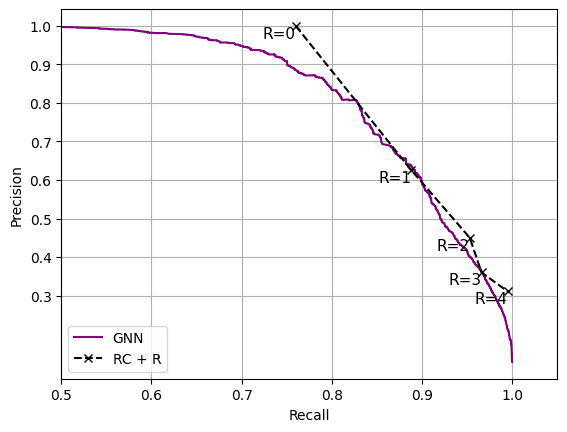

In [16]:
# RC + R stats
recall_from_rcr = [0.76, 0.888, 0.953, 0.966, 0.995]
precision_from_rcr = [1.0, 0.626, 0.450, 0.360, 0.311]
r_labels = [f"R={i}" for i in range(len(recall_from_rcr))]

precision, recall, thresholds = precision_recall_curve(pred_df.y, pred_df.y_pred)
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple', label="GNN")
ax.plot(recall_from_rcr, precision_from_rcr, ls='--', marker="x", color='black', label="RC + R")
ax.set_xticks(np.arange(0.4, 1.05, 0.1))
ax.set_yticks(np.arange(0.3, 1.05, 0.1))
ax.set_xlim(0.5, 1.05)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
for r, p, label in zip(recall_from_rcr, precision_from_rcr, r_labels):
    ax.text(r, p, label, fontsize=11, ha='right', va='top', color='black')
ax.grid()
ax.legend(loc='lower left')
plt.show()